In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import shap
shap.initjs()

# IDEA + QUESTIONS

# DATA ANALYSIS

In [3]:
df_old = pd.read_csv("4s_data.csv")
df_train = pd.read_csv("4S_2023-12-05.csv")
df_test1 = pd.read_csv("4S_2023-12-05_test_1.csv")
df_test2 = pd.read_csv("4S_2023-12-05_test_2.csv")

Attached is a csv file with the data we can use to begin with. The rows represent the samples while the features are in the columns. The last column ('sat1_col') is the response variable, i.e., the collapse capacity for each ground motion. There are 88 ground motions, i.e., 88 rows, in this data set.

Here are a few notes related to the predictive features:

- the columns called by numbers (e.g., 0.42) represent the spectral accelerations at the specified period -- for instance, column 0.42 indicates Sa(T = 0.42s), i.e., the spectral acceleration at period T = 0.42s. The units for Sa(T) are in 'g'. 

- 'sa_avg' feature corresponds to average spectral acceleration, where averaging was performed over some favorable range of periods (I can provide more details, but currently this is not important)

- features 'da5_75' and 'da5_95' are significant durations of the ground motion, unit is second

- 'fiv3' is the so-called filtered incremental velocity, unit cm/s

- the 'fiv3_sa_avg' (unit: second) and 'sa_ratio' (no unit) are two additional useful features

These predictive features are currently the state-of-the art in terms of describing the ground motion waveform using a set of scalars. People have been studying ground motion properties extensively and as a result we can distill this into these features which should have you in good shape for the project. These scalars are generally called ground motion intensity measures (IMs).

As discussed, the objective is to develop a regression-based data-driven surrogate that maps the predictive features onto 'sat1_col'. In other words, given a ground motion described by IMs, the model should output the corresponding collapse capacity. In terms of first steps, I suggest the following:
1) look at the data and try plotting the spectra, see the range of ground motion intensities that are present
2) look at the data* and try observing if there are some patterns that emerge --- basically, doing exploratory data analysis
3) try developing a simple surrogate model as a baseline -- feel free to split the provided data into train/validation and test sets as you like
4) given the baseline surrogate, look into feature importance -- which of these features seem to be most important?
5) see how this goes and ask any questions

We can plan to meet next week once you have some experience with this dataset. Just a few more comments what we'll do down the line -- we will have to discuss how to potentially "massage" this dataset to get more points for regression (basically data engineering); I will also provide you with a separate "test" dataset which you will be able to use to see how your surrogate does.

Let me know if there are any questions and have fun doing the project! I am looking forward to your results.


Collapse capacity = lowest intensity at which the groud motion induces collapse

Sa_ratio = Sa(T1)/Sa,avg -> independent of scaling

da_5_75 -> duration when the gm release 75% of energy (idnependant fo scaling)
fiv -> linear dependent of the scaling

When the building is damage, T increase

Fiv ratio = Fiv/Sa_avg, Fiv add the information of the time (Sa don't)

only sa ,sa_avg and fiv 3 scale linearly

In [4]:
df_numpy = df_train.to_numpy()
dfhead_numpy = df_train.columns.to_numpy()

df_test1_numpy = df_test1.to_numpy()
df_test2_numpy = df_test2.to_numpy()

In [5]:
print(df_train.isnull().values.any())
print(df_test1.isnull().values.any())
print(df_test2.isnull().values.any())

False
False
False


In [6]:
df_old

,Unnamed: 0,0.42,0.48,0.54,0.6,0.66,0.72,0.78,0.84,0.9,...,6.18,6.24,6.3,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
0,0,0.575990,0.634012,0.984589,0.651638,0.552142,0.513674,0.648066,0.871627,0.826833,...,0.012103,0.011779,0.011465,0.069200,6.080,9.220,72.137797,1.062640,1.853447,0.932767
1,1,0.896211,1.304416,1.543180,1.113115,0.689017,0.550542,0.588670,0.768486,0.768595,...,0.008579,0.008367,0.008163,0.060232,4.970,8.390,67.461330,1.141723,1.758348,0.760412
2,2,1.082617,0.968053,1.000421,0.910550,0.576288,0.552972,0.563723,0.494189,0.540344,...,0.032789,0.032189,0.031584,0.097871,2.620,8.520,79.997347,0.833204,1.655255,0.875986
3,3,0.849378,0.859986,0.755665,0.743255,0.749674,0.804410,0.839647,0.864842,0.846432,...,0.012952,0.012546,0.012152,0.068796,1.480,9.350,74.235966,1.099966,2.459418,0.662390
4,4,0.367455,0.443266,0.451825,0.409128,0.356187,0.328962,0.361279,0.344421,0.317798,...,0.039085,0.038664,0.038225,0.084427,6.360,11.660,73.982543,0.893261,1.301475,1.025093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,0.781084,0.761288,1.052943,0.954739,1.122963,0.950573,0.898066,0.761042,0.689891,...,0.036275,0.035084,0.033112,0.110600,68.790,112.520,82.034242,0.756089,1.460307,0.387620
84,84,0.981351,0.955204,0.827847,0.536066,0.693835,0.587537,0.704240,0.625330,0.588425,...,0.086046,0.079670,0.073873,0.202654,70.150,107.840,151.028729,0.759690,1.696002,0.367451
85,85,0.595830,0.726171,0.573850,0.520347,0.489539,0.440949,0.428664,0.553211,0.503269,...,0.029629,0.028638,0.027619,0.104806,71.210,110.070,84.456690,0.821444,2.473173,0.514672
86,86,0.394897,0.461244,0.533049,0.505265,0.684984,0.708273,0.515718,0.443249,0.556150,...,0.016659,0.016326,0.015987,0.086041,71.740,115.000,87.346939,1.034835,1.312010,0.277765


In [7]:
df_train

,0.26,0.3,0.33,0.37,0.41,0.44,0.48,0.52,0.55,0.59,...,3.83,3.86,3.9,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
0,0.654528,0.545947,0.499935,0.403530,0.569591,0.600255,0.634012,0.992002,0.937329,0.707388,...,0.033665,0.033217,0.032652,0.170767,6.080,9.220,70.998884,0.423816,2.587166,2.13
1,0.730026,0.827603,0.724967,0.579945,0.792750,1.070260,1.304416,1.538292,1.505293,1.205043,...,0.029806,0.029303,0.028641,0.167651,4.970,8.390,85.647839,0.520765,2.736270,2.42
2,0.685137,0.702085,0.891422,0.946785,0.850194,0.739755,0.850181,0.868407,1.002069,1.177702,...,0.045195,0.044400,0.043358,0.186269,3.150,6.260,104.557865,0.572198,0.999323,0.63
3,0.892942,0.959937,1.098083,0.890052,0.861089,0.870705,0.910596,0.947218,0.910967,0.824203,...,0.044495,0.043683,0.042601,0.159729,2.940,5.560,70.357460,0.449010,1.631756,1.33
4,1.296670,1.363284,1.348281,1.028503,1.053261,1.099231,0.968053,1.003986,1.027320,0.958117,...,0.050916,0.049059,0.048209,0.186094,2.620,8.520,75.957903,0.416075,1.248612,1.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.627354,0.509651,0.458420,0.453122,0.564346,0.549482,0.433097,0.266118,0.251908,0.288433,...,0.089055,0.086068,0.082013,0.146475,25.710,74.470,66.684919,0.464082,1.279688,1.06
84,0.936735,0.774153,0.897960,0.848487,1.070663,1.356263,1.220404,1.267861,1.284577,1.089581,...,0.059486,0.058402,0.056617,0.127609,27.670,103.960,58.584579,0.467986,1.368178,0.72
85,0.870894,0.794892,0.610460,0.656388,0.638343,0.562847,0.673777,0.617406,0.773041,0.711265,...,0.211319,0.216509,0.219433,0.339486,33.330,53.860,175.671052,0.527484,1.052909,0.90
86,1.273088,1.111318,1.413050,1.160315,1.080836,1.109315,1.408342,1.280291,1.203599,1.136133,...,0.059265,0.058553,0.057390,0.158762,38.205,97.045,73.367647,0.471075,1.758459,0.80


In [8]:
df_test1

,0.26,0.3,0.33,0.37,0.41,0.44,0.48,0.52,0.55,0.59,...,3.83,3.86,3.9,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
0,0.080453,0.072544,0.071159,0.074085,0.063869,0.062709,0.063830,0.076104,0.062837,0.051526,...,0.002575,0.002447,0.002267,0.007903,6.410,11.350,3.967704,0.511763,2.422406,1.70
1,0.050469,0.045989,0.036266,0.036878,0.040137,0.033033,0.033181,0.041473,0.045394,0.040922,...,0.033903,0.034224,0.034498,0.034534,28.690,63.415,25.361605,0.748621,1.092641,0.87
2,0.023669,0.028840,0.031953,0.033732,0.032392,0.034742,0.029688,0.030087,0.030524,0.028031,...,0.011654,0.011211,0.010642,0.022918,35.790,107.500,10.936858,0.486451,1.759189,1.35
3,0.001169,0.001304,0.001054,0.001001,0.001142,0.001175,0.001204,0.001076,0.000972,0.001239,...,0.000790,0.000804,0.000802,0.000921,36.720,71.080,0.537871,0.595473,1.148632,0.84
4,0.090417,0.105047,0.122271,0.131664,0.126803,0.103147,0.070264,0.060667,0.054543,0.049890,...,0.011481,0.011551,0.011591,0.022241,18.520,28.000,9.615929,0.440717,1.656612,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.027425,0.028734,0.022707,0.019836,0.018359,0.019530,0.016658,0.012400,0.011722,0.011843,...,0.003914,0.003822,0.003703,0.007838,35.320,92.660,4.044068,0.525980,1.378634,1.11
96,0.055504,0.043961,0.047317,0.050101,0.048611,0.042549,0.047753,0.039621,0.038541,0.035678,...,0.013804,0.013315,0.012572,0.029501,26.995,38.565,15.731262,0.543573,1.405346,1.19
97,0.468394,0.662024,0.661232,0.869139,1.117651,1.237983,0.965495,0.610487,0.498653,0.346151,...,0.014061,0.013893,0.013679,0.046196,3.680,9.065,17.577605,0.387873,1.509819,1.04
98,0.003673,0.002517,0.002803,0.003510,0.004079,0.003513,0.003125,0.002470,0.002110,0.001833,...,0.000892,0.000889,0.000879,0.001257,18.000,36.740,0.607488,0.492672,0.660534,0.70


In [9]:
dfhead_numpy

array(['0.26', '0.3', '0.33', '0.37', '0.41', '0.44', '0.48', '0.52',
       '0.55', '0.59', '0.63', '0.66', '0.7', '0.74', '0.77', '0.81',
       '0.85', '0.89', '0.92', '0.96', '1', '1.03', '1.07', '1.11',
       '1.14', '1.18', '1.22', '1.25', '1.29', '1.3', '1.33', '1.36',
       '1.4', '1.44', '1.47', '1.51', '1.55', '1.58', '1.62', '1.66',
       '1.69', '1.73', '1.77', '1.8', '1.84', '1.88', '1.91', '1.95',
       '1.99', '2.02', '2.06', '2.1', '2.14', '2.17', '2.21', '2.25',
       '2.28', '2.32', '2.36', '2.39', '2.43', '2.47', '2.5', '2.54',
       '2.58', '2.61', '2.65', '2.69', '2.72', '2.76', '2.8', '2.83',
       '2.87', '2.91', '2.94', '2.98', '3.02', '3.05', '3.09', '3.13',
       '3.16', '3.2', '3.24', '3.27', '3.31', '3.35', '3.39', '3.42',
       '3.46', '3.5', '3.53', '3.57', '3.61', '3.64', '3.68', '3.72',
       '3.75', '3.79', '3.83', '3.86', '3.9', 'sa_avg', 'da5_75',
       'da5_95', 'fiv3', 'fiv3_sa_avg', 'sa_ratio', 'sat1_col'],
      dtype=object)

In [10]:
Period = dfhead_numpy[:-7]
df_period = df_train[Period]
df_value = df_train[['sa_avg','da5_75','da5_95','fiv3','fiv3_sa_avg','sa_ratio','sat1_col']]
#df_scaled_period= df_period.div(df_period['0.78'], axis=0)
#df_scaled_numpy = pd.concat([df_scaled_period, df_value], axis=1).to_numpy()

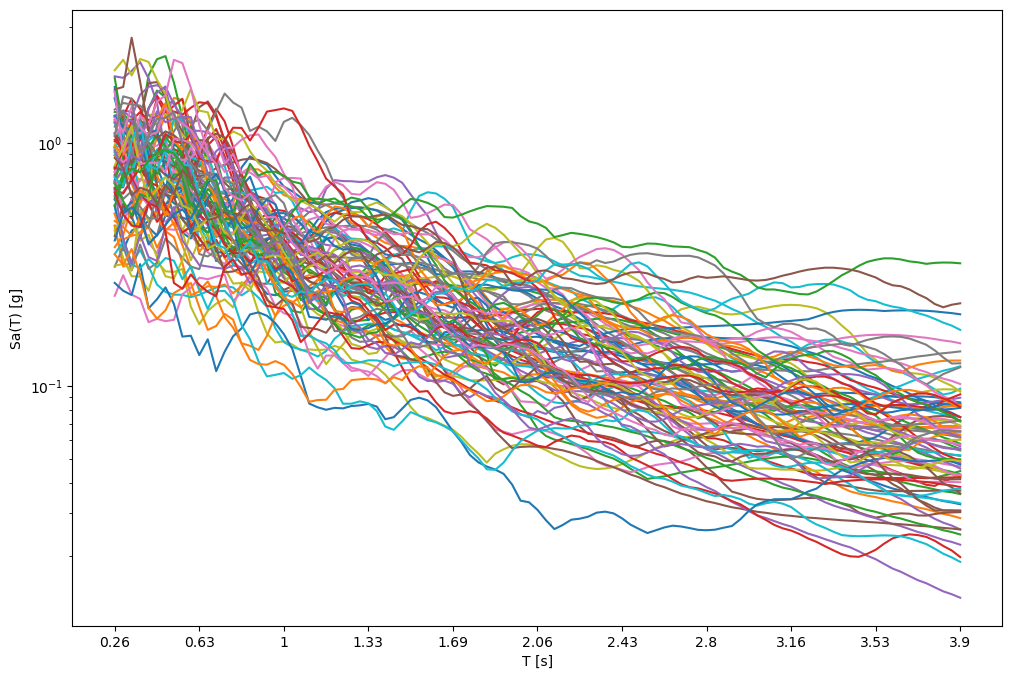

In [11]:
plt.figure(figsize=(12,8))
Period = dfhead_numpy[:-7]
for i in range(len(df_numpy)):
    plt.plot(Period,df_numpy[i,:-7])
plt.ylabel("Sa(T) [g]")
plt.yscale('log')
#plt.yscale("log")
plt.xlabel("T [s]")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

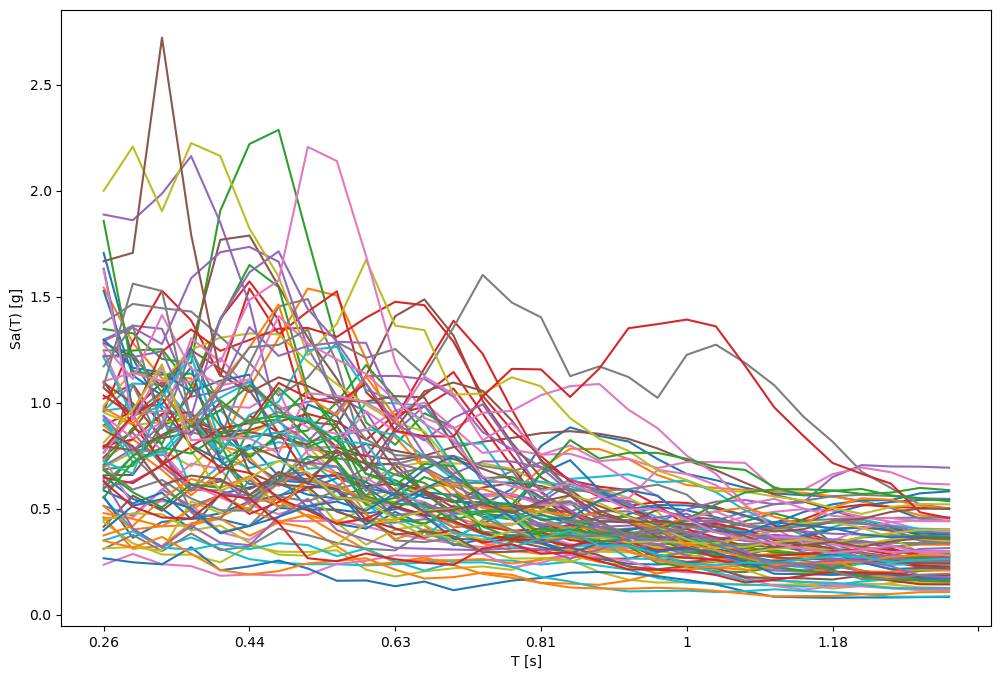

In [12]:
plt.figure(figsize=(12,8))
Period = dfhead_numpy[:30]
for i in range(len(df_numpy)):
    plt.plot(Period,df_numpy[i,:30])
plt.ylabel("Sa(T) [g]")
plt.xlabel("T [s]")
plt.xticks([0,5,10,15,20,25,30])
plt.show()

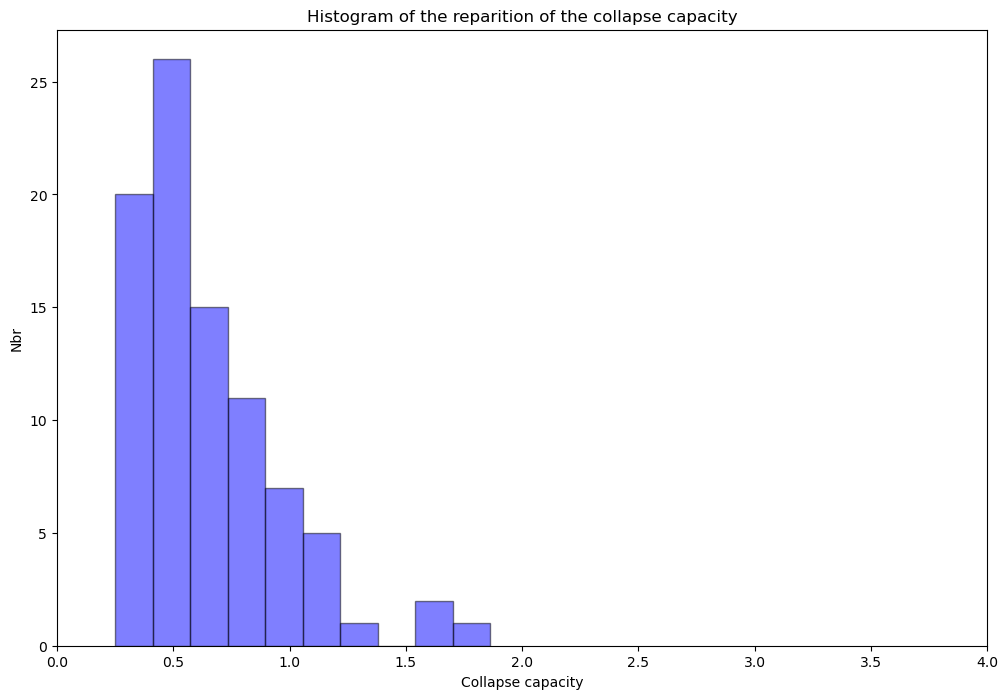

In [13]:
plt.figure(figsize=(12,8))
plt.hist(df_old['sat1_col'], bins=10, color='blue', edgecolor='black',alpha=0.5)
#plt.hist(df_test1['sat1_col'], bins=10, color='red', edgecolor='black',alpha=0.5)
#plt.hist(df_test2['sat1_col'], bins=10, color='green', edgecolor='black',alpha=0.5)
plt.xlim(0,4)
plt.xlabel('Collapse capacity')
plt.ylabel('Nbr')
plt.title('Histogram of the reparition of the collapse capacity')
plt.show()

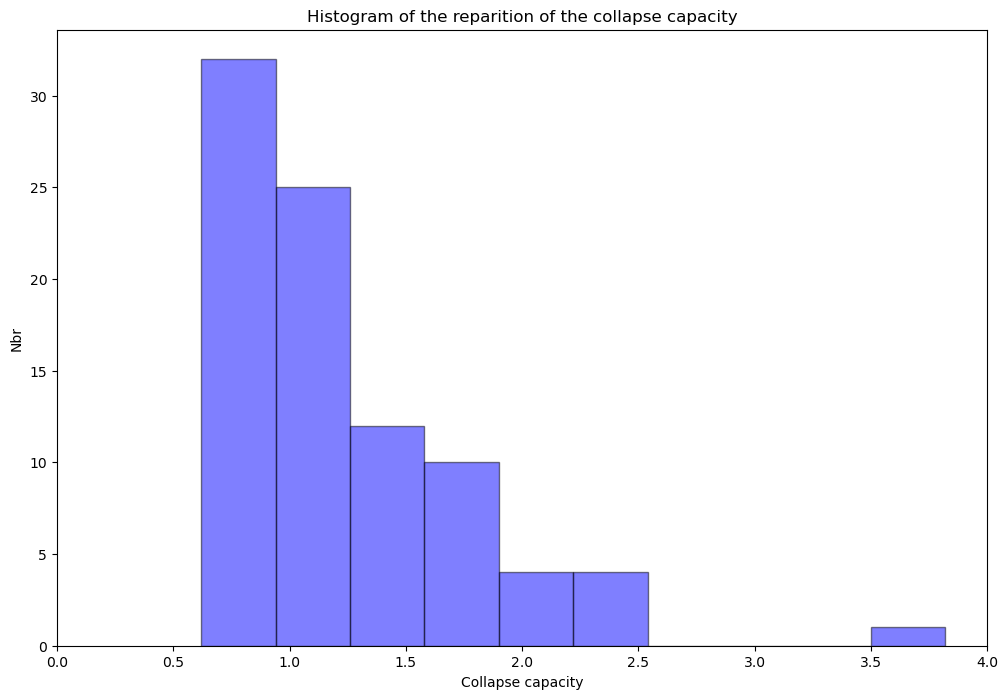

In [14]:
plt.figure(figsize=(12,8))
plt.hist(df_train['sat1_col'], bins=10, color='blue', edgecolor='black',alpha=0.5)
#plt.hist(df_test1['sat1_col'], bins=10, color='red', edgecolor='black',alpha=0.5)
#plt.hist(df_test2['sat1_col'], bins=10, color='green', edgecolor='black',alpha=0.5)
plt.xlim(0,4)
plt.xlabel('Collapse capacity')
plt.ylabel('Nbr')
plt.title('Histogram of the reparition of the collapse capacity')
plt.show()

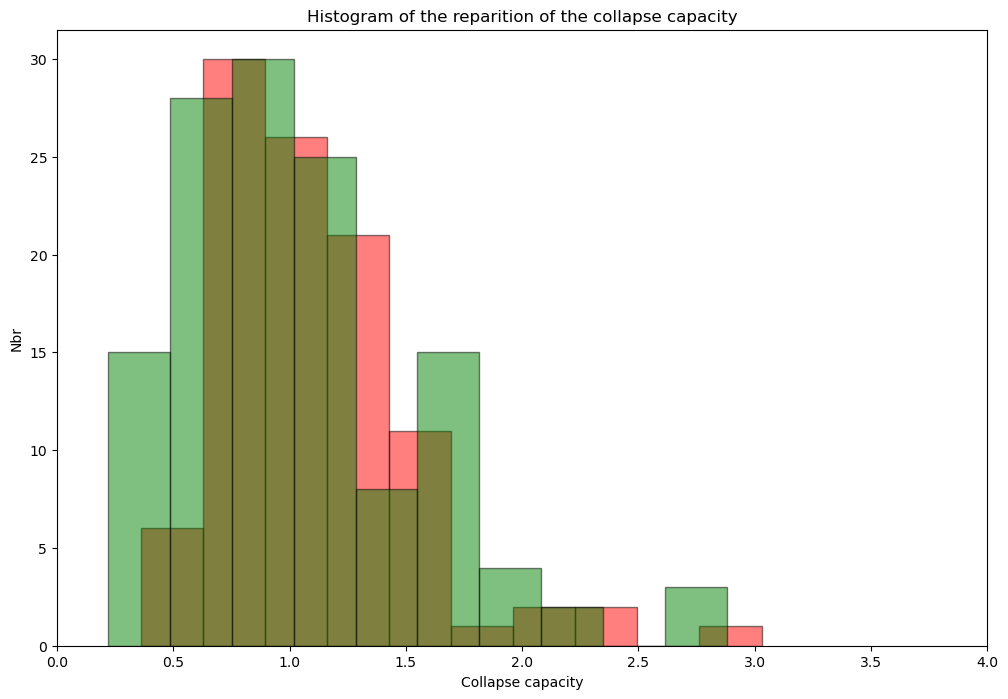

In [15]:
plt.figure(figsize=(12,8))
plt.hist(df_test1['sat1_col'], bins=10, color='red', edgecolor='black',alpha=0.5)
plt.hist(df_test2['sat1_col'], bins=10, color='green', edgecolor='black',alpha=0.5)
plt.xlim(0,4)
plt.xlabel('Collapse capacity')
plt.ylabel('Nbr')
plt.title('Histogram of the reparition of the collapse capacity')
plt.show()

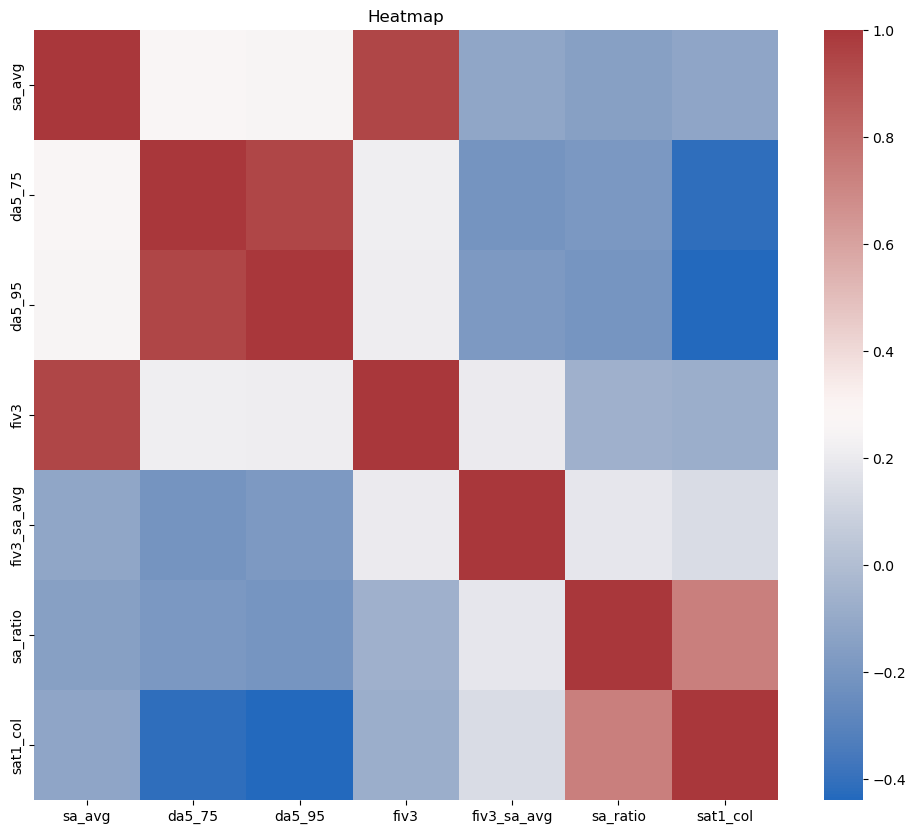

In [16]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.heatmap(df_train[['sa_avg', 'da5_75', 'da5_95', 'fiv3',
                'fiv3_sa_avg', 'sa_ratio', 'sat1_col']].corr(), cmap='vlag')
plt.title('Heatmap')
plt.show()

 FIV3, which is based directly on features of the ground acceleration time history instead of peak responses of one or many linear elastic oscillators like Sa or Saavg.

# MODELS

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [123]:
#X = df_numpy[:,:-1] #All data
#X = df_numpy[:,-7:] #All "resume" features
#X = df_numpy[:,:-7] #All Sa
#X = df_numpy[:,:50] #First 50 Sa
# X = (df_numpy[:,:-1]-np.mean(df_numpy[:,:-1]))/np.std(df_numpy[:,:-1])
X=df_numpy[:,:-1]

y = df_numpy[:,-1] #Collapse capacity

X_test1 = df_test1_numpy[:,:-1]
X_test2 = df_test2_numpy[:,:-1]
y_test1 = df_test1_numpy[:,-1]
y_test2 = df_test2_numpy[:,-1]

In [124]:
X

array([[  0.65452758,   0.54594736,   0.49993495, ...,  70.9988844 ,
          0.42381608,   2.58716638],
       [  0.73002608,   0.82760257,   0.72496692, ...,  85.64783852,
          0.520765  ,   2.73626986],
       [  0.68513694,   0.70208456,   0.89142239, ..., 104.5578647 ,
          0.5721978 ,   0.99932317],
       ...,
       [  0.87089376,   0.79489236,   0.61045967, ..., 175.6710519 ,
          0.52748421,   1.05290942],
       [  1.27308839,   1.11131834,   1.41305025, ...,  73.36764685,
          0.47107525,   1.75845921],
       [  1.07765274,   1.56139407,   1.52644761, ...,  74.30803278,
          0.49362435,   1.25758724]])

In [181]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

# df_norm = df_train.copy()
# # df_norm.iloc[:,:] = scaler.fit_transform(df_norm.iloc[:,:].to_numpy())

# X = df_norm[df_norm.columns[:-1]]
# X.iloc[:,:] = scaler.fit_transform(X.iloc[:,:].to_numpy())
# y = df_train[df_norm.columns[-1]]
# # y.iloc[:] = scaler.fit_transform(y.iloc[:].to_numpy())

# X_test1 = df_test1[df_test1.columns[:-1]]
# X_test1[:,:] = scaler.fit_transform(X_test1[:,:].to_numpy())
# X_test2 = df_test2[df_test2.columns[:-1]]
# X_test2[:,:] = scaler.fit_transform(X_test2[:,:].to_numpy())
# y_test1 = df_test1[df_test1.columns[-1]]
# y_test2 = df_test2[df_test2.columns[-1]]

X_train = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]

# Fit and transform the training data
X_train_scaled_np = scaler.fit_transform(X_train)
X = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)


# Transform the test data with the same scaler
X_test1 = df_test1.iloc[:, :-1]
X_test2 = df_test2.iloc[:, :-1]
X_test1_scaled_np = scaler.transform(X_test1)
X_test2_scaled_np = scaler.transform(X_test2)
X_test1 = pd.DataFrame(X_test1_scaled_np, columns=X_test1.columns, index=X_test1.index)
X_test2 = pd.DataFrame(X_test2_scaled_np, columns=X_test2.columns, index=X_test2.index)

y_test1 = df_test1.iloc[:, -1]
y_test2 = df_test2.iloc[:, -1]

In [182]:
X

,0.26,0.3,0.33,0.37,0.41,0.44,0.48,0.52,0.55,0.59,...,3.79,3.83,3.86,3.9,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio
0,0.237467,0.152410,0.105701,0.087508,0.195023,0.202325,0.213571,0.398436,0.392723,0.356634,...,0.063330,0.062714,0.062507,0.062456,0.285274,0.059532,0.034891,0.264177,0.165246,0.656320
1,0.280268,0.296069,0.196297,0.175917,0.307730,0.433812,0.532611,0.669050,0.679672,0.681715,...,0.050900,0.050217,0.049832,0.049400,0.277293,0.045166,0.029070,0.347915,0.432088,0.711156
2,0.254820,0.232048,0.263310,0.359758,0.336743,0.271031,0.316444,0.337212,0.425431,0.663855,...,0.102329,0.100056,0.098726,0.097308,0.324969,0.021613,0.014132,0.456012,0.573651,0.072358
3,0.372628,0.363566,0.346509,0.331326,0.342246,0.335527,0.345195,0.376252,0.379404,0.432941,...,0.100054,0.097787,0.096404,0.094844,0.257009,0.018895,0.009223,0.260510,0.234590,0.304948
4,0.601506,0.569294,0.447235,0.400710,0.439303,0.448080,0.372539,0.404373,0.438189,0.520417,...,0.125584,0.118581,0.113819,0.113099,0.324520,0.014753,0.029982,0.292524,0.143939,0.164039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.222062,0.133897,0.088988,0.112361,0.192374,0.177318,0.117958,0.038858,0.046433,0.082963,...,0.250871,0.242099,0.233684,0.223133,0.223070,0.313576,0.492513,0.239517,0.276074,0.175468
84,0.397455,0.268807,0.265942,0.310496,0.448091,0.574674,0.492630,0.535088,0.568161,0.606292,...,0.148267,0.146337,0.144079,0.140467,0.174760,0.338941,0.699337,0.193212,0.286818,0.208012
85,0.360128,0.279385,0.150197,0.214226,0.229747,0.183900,0.232495,0.212874,0.309721,0.359167,...,0.661254,0.638061,0.656166,0.670453,0.717306,0.412191,0.347968,0.862521,0.450582,0.092065
86,0.588138,0.440779,0.473311,0.466767,0.453230,0.453047,0.582068,0.541245,0.527249,0.636701,...,0.145772,0.145621,0.144569,0.142982,0.254531,0.475281,0.650840,0.277717,0.295322,0.351546


In [183]:
y

0     2.13
1     2.42
2     0.63
3     1.33
4     1.28
      ... 
83    1.06
84    0.72
85    0.90
86    0.80
87    0.90
Name: sat1_col, Length: 88, dtype: float64

## FACK

In [212]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# Function definition for Francisco's Anti-Clustering Kmeans (FACK)
def FACK(data, n_points_cluster1):
    # Ensure 'data' is a copy to avoid SettingWithCopyWarning
    data = data.copy()

    # Run K-means with explicit 'n_init' value
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(data)
    data['cluster'] = kmeans.labels_

    # Calculate distances to the centroids
    centroids = kmeans.cluster_centers_
    distances = euclidean_distances(data.drop('cluster', axis=1), centroids)

    # Create DataFrame for sorting and assigning
    data_with_distances = data.copy()
    data_with_distances['distance_to_centroid'] = np.where(data_with_distances['cluster'] == 0, distances[:, 0], distances[:, 1])
    
    # Sort each original cluster by distance to centroid
    sorted_cluster_0 = data_with_distances[data_with_distances['cluster'] == 0].sort_values(by='distance_to_centroid')
    sorted_cluster_1 = data_with_distances[data_with_distances['cluster'] == 1].sort_values(by='distance_to_centroid')

    # Assign to new anti-clusters
    new_cluster_labels = []
    i = j = 0
    total_points = len(data)
    for _ in range(total_points):
        if len(new_cluster_labels) < n_points_cluster1:
            new_cluster = 1
        else:
            new_cluster = 2

        if i <= j and i < len(sorted_cluster_0):
            new_cluster_labels.append((sorted_cluster_0.iloc[i].name, new_cluster))
            i += 1
        elif j < len(sorted_cluster_1):
            new_cluster_labels.append((sorted_cluster_1.iloc[j].name, new_cluster))
            j += 1

    # Create a DataFrame from the new cluster assignments
    new_cluster_df = pd.DataFrame(new_cluster_labels, columns=['index', 'new_cluster']).set_index('index')
    data_with_clusters = data.join(new_cluster_df, how='left')

    return data_with_clusters

# Load the dataset
df = df_train.copy()

# Selecting the specified columns for FACK
data_to_cluster = df[['fiv3_sa_avg', 'sa_ratio']].copy() 

# Determine the number of data points for the first cluster
# For this example, let's say we want half of the data points in the first cluster
n_points_cluster1 = len(data_to_cluster) // 2

# Run FACK on the dataset
df_with_clusters = FACK(data_to_cluster, n_points_cluster1)

# Add the new cluster assignments to the original dataset
df['clusters'] = df_with_clusters['new_cluster']

print(df.head())  # Display the first few rows of the modified dataset

       0.26       0.3      0.33      0.37      0.41      0.44      0.48  \
0  0.654528  0.545947  0.499935  0.403530  0.569591  0.600255  0.634012   
1  0.730026  0.827603  0.724967  0.579945  0.792750  1.070260  1.304416   
2  0.685137  0.702085  0.891422  0.946785  0.850194  0.739755  0.850181   
3  0.892942  0.959937  1.098083  0.890052  0.861089  0.870705  0.910596   
4  1.296670  1.363284  1.348281  1.028503  1.053261  1.099231  0.968053   

       0.52      0.55      0.59  ...      3.86       3.9    sa_avg  da5_75  \
0  0.992002  0.937329  0.707388  ...  0.033217  0.032652  0.170767    6.08   
1  1.538292  1.505293  1.205043  ...  0.029303  0.028641  0.167651    4.97   
2  0.868407  1.002069  1.177702  ...  0.044400  0.043358  0.186269    3.15   
3  0.947218  0.910967  0.824203  ...  0.043683  0.042601  0.159729    2.94   
4  1.003986  1.027320  0.958117  ...  0.049059  0.048209  0.186094    2.62   

   da5_95        fiv3  fiv3_sa_avg  sa_ratio  sat1_col  clusters  
0    9.22   7

# SGD

Training/Validation

In [184]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty='l1',learning_rate='adaptive',max_iter=100000)

param_grid = {
    'alpha': np.logspace(-4, 0, 30),
}

grid_search = GridSearchCV(sgd_reg, param_grid, cv=5)

grid_search.fit(X, y)

best_params = grid_search.best_params_

Testing

In [185]:
SEED = 42
np.random.seed(SEED)

sgd_reg = SGDRegressor(**best_params)
sgd_reg.fit(X, y)

y_pred_test1 = sgd_reg.predict(X_test1)
y_pred_test2 = sgd_reg.predict(X_test2)

MSE_Test_SGD1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_SGD2 = mean_squared_error(y_test2, y_pred_test2)

print(f"SGD Mean Squared Error test1: {round(np.mean(MSE_Test_SGD1),2)}")
print(f"SGD Mean Squared Error test2: {round(np.mean(MSE_Test_SGD2),2)}")

SGD Mean Squared Error test1: 0.3
SGD Mean Squared Error test2: 0.3


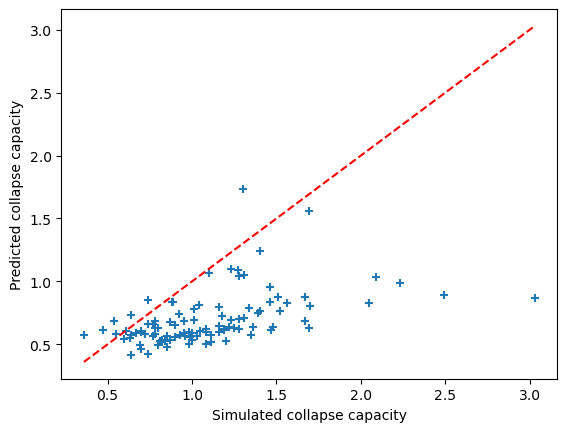

In [186]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

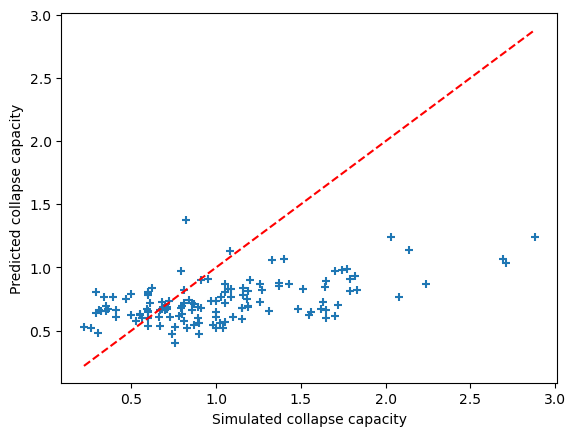

In [187]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

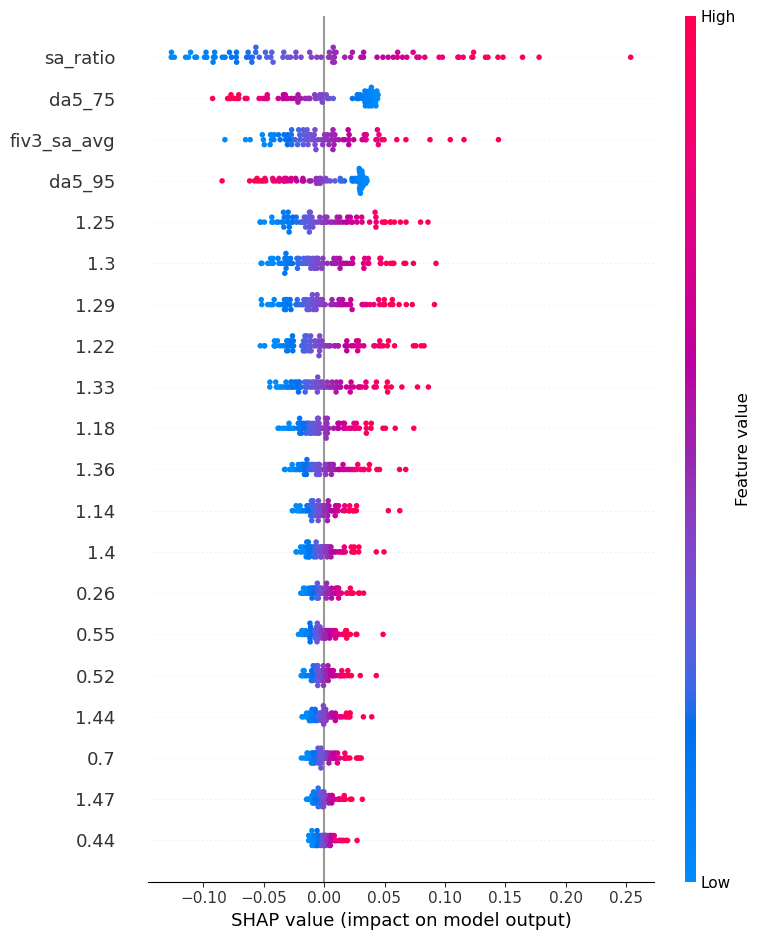

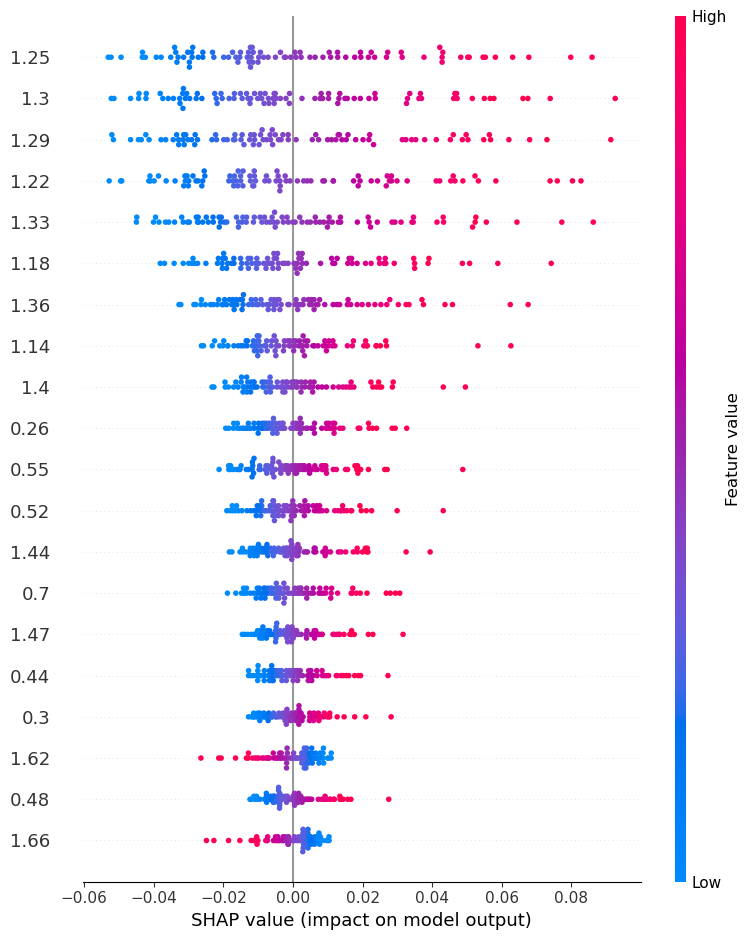

In [188]:
explainer = shap.Explainer(sgd_reg, X[0:88])
shap_values = explainer(X[0:88])
shap.summary_plot(shap_values)
shap.summary_plot(shap_values[:,:-6], X.iloc[:, :-6])

# Ridge regression

Training/Validation

In [217]:
from sklearn.linear_model import Ridge

lin_reg = Ridge()


param_grid = {
    'alpha': np.logspace(-4, 0, 30),
}

grid_search = GridSearchCV(lin_reg, param_grid, cv=5)

grid_search.fit(X, y)

best_params = grid_search.best_params_

Testing

In [218]:
lin_reg = Ridge(**best_params)
lin_reg.fit(X, y)

y_pred_test1 = lin_reg.predict(X_test1)
y_pred_test2 = lin_reg.predict(X_test2)

MSE_Test_RIDGE1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_RIDGE2 = mean_squared_error(y_test2, y_pred_test2)

print(f"RIDGE Mean Squared Error test1: {round(np.mean(MSE_Test_RIDGE1),2)}")      
print(f"RIDGE Mean Squared Error test2: {round(np.mean(MSE_Test_RIDGE2),2)}")      

RIDGE Mean Squared Error test1: 0.1
RIDGE Mean Squared Error test2: 0.34


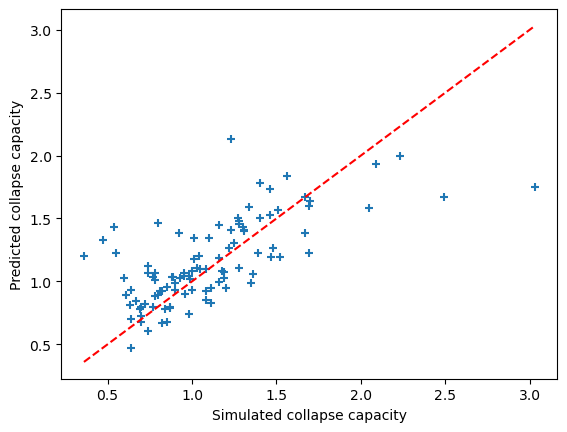

In [219]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

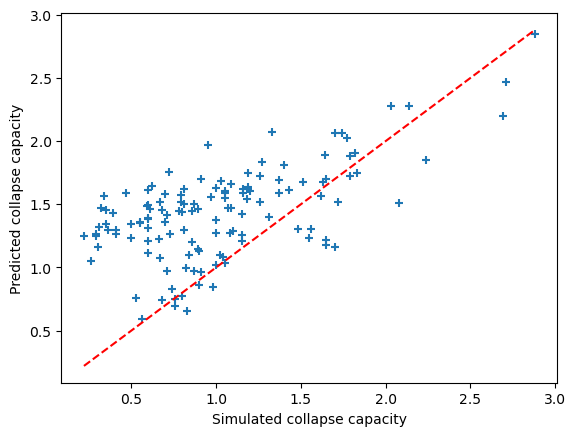

In [220]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

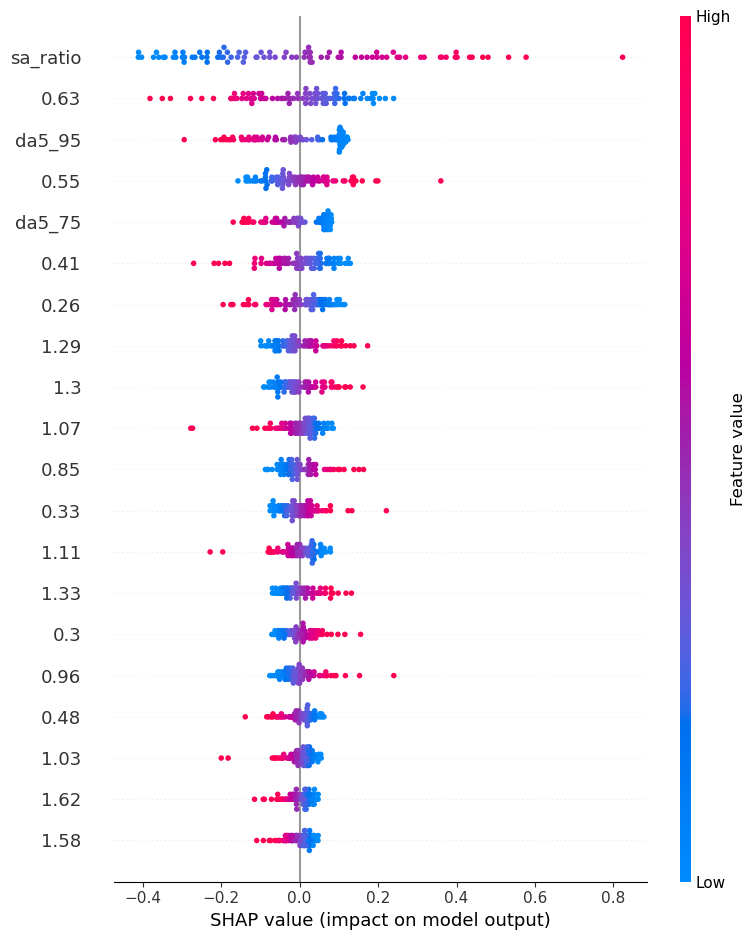

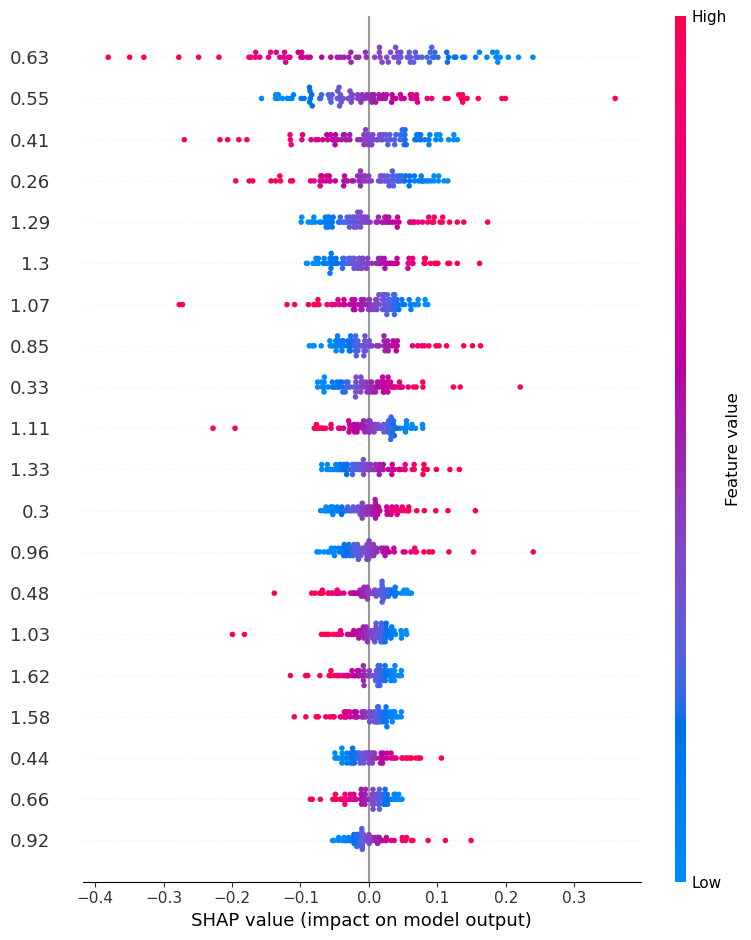

In [221]:
explainer = shap.Explainer(lin_reg, X[0:88])
shap_values = explainer(X[0:88])
shap.summary_plot(shap_values)
shap.summary_plot(shap_values[:,:-6], X.iloc[:, :-6])

In [237]:
points = [88,78,68,58,48,38,28,18,8]
MSE_points = []

for i in points:
    n_points_cluster1 = i
    df_with_clusters = FACK(data_to_cluster, n_points_cluster1)
    df['clusters'] = df_with_clusters['new_cluster']

    X_1 = df[df['clusters']==1].iloc[:,:-2]
    # X_2 = df[df['clusters']==2].iloc[:,:-2]
    y_1 = df[df['clusters']==1].iloc[:,-2]
    # y_2 = df[df['clusters']==2].iloc[:,-1]

    lin_reg = Ridge(**best_params)
    lin_reg.fit(X_1, y_1)
    print(X_1.shape)

    y_pred_test2 = lin_reg.predict(X_test2)
    # y_pred_test2 = lin_reg.predict(X_test2)

    mse_i = mean_squared_error(y_test2, y_pred_test2)

    MSE_points.append(mse_i)

    print(i, mse_i)
    # MSE_Test_RIDGE2 = mean_squared_error(y_test2, y_pred_test2)

mplot = plt.plot(points,MSE_points)

(88, 107)
88 0.5207996068873666
(78, 107)
78 0.4550923952255038
(68, 107)
68 0.48590844724042764
(58, 107)
58 0.34875482683166004
(48, 107)
48 0.28517915615745826
(38, 107)
38 0.2323375878267991
(28, 107)
28 0.2531211593497245
(18, 107)
18 0.2176196561122529
(8, 107)
8 0.43127798196935796


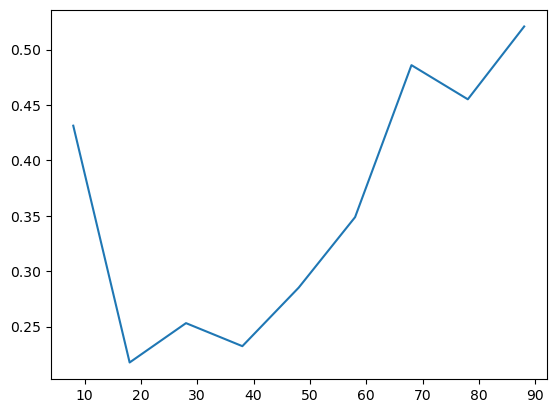

In [236]:
mplot = plt.plot(points,MSE_points)

# MLP

In [195]:
X_train = X.to_numpy()
y_train = y.to_numpy()

MLP Mean Squared Error test1: 0.28
MLP Mean Squared Error test2: 0.26


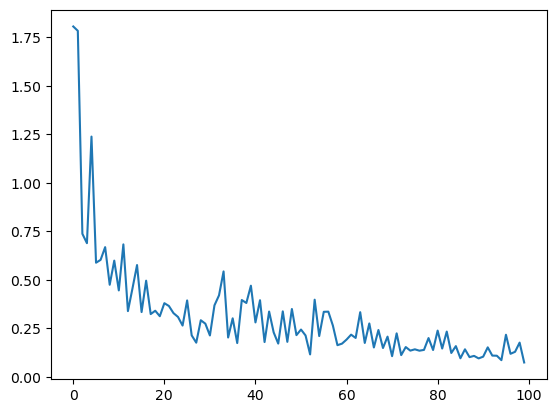

In [196]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

hidden_size = 64 
output_size = 1
max_iterations = 1000

MSE_Train_MLP = np.zeros((1,max_iterations))
MSE_Test_MLP = np.zeros((1,max_iterations))

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
input_size = X_train.shape[1]

model = RegressionModel(input_size, hidden_size, output_size)

# MSE and Adam
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    losses.append(loss.detach().numpy())

# Testing
X_test1_tensor = torch.FloatTensor(X_test1.to_numpy())
X_test2_tensor = torch.FloatTensor(X_test2.to_numpy())

with torch.no_grad():
    model.eval()
    y_pred_test1 = model(X_test1_tensor)
    y_pred_test2 = model(X_test2_tensor)

    MSE_Test_MLP1 = mean_squared_error(y_test1, y_pred_test1)
    MSE_Test_MLP2 = mean_squared_error(y_test2, y_pred_test2)

print(f"MLP Mean Squared Error test1: {round(np.mean(MSE_Test_MLP1),2)}")        
print(f"MLP Mean Squared Error test2: {round(np.mean(MSE_Test_MLP2),2)}")        

plt.plot(losses)

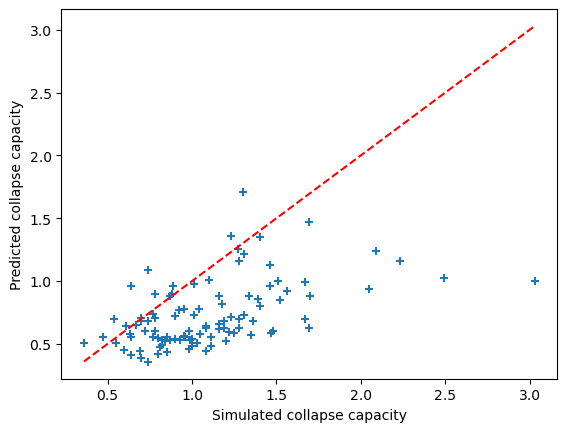

In [197]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

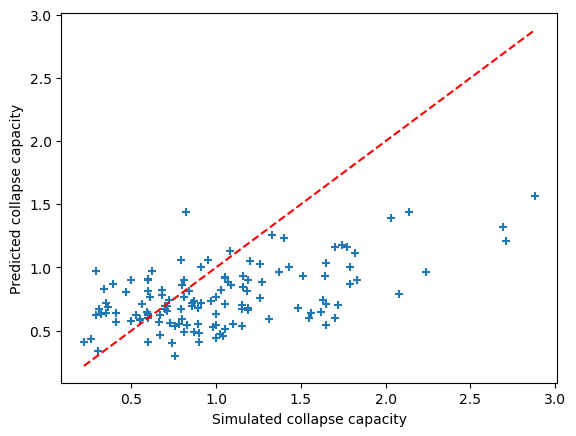

In [198]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

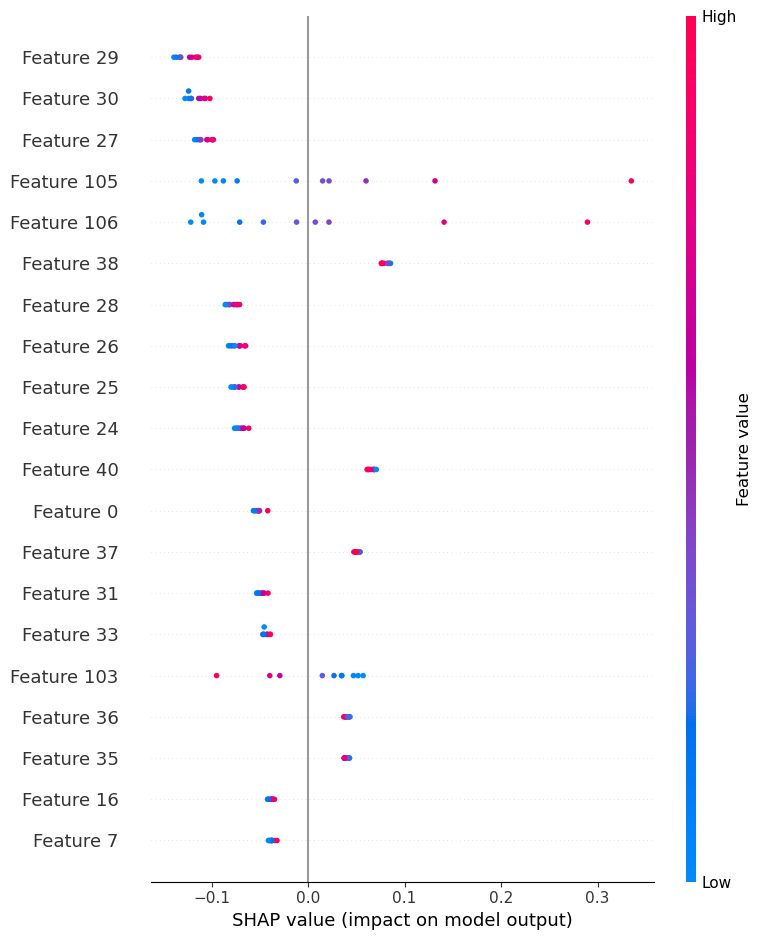

In [199]:
background = X_train_tensor[:88]  # Using 100 instances from the training set as background
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
X_test_sample = X_test1_tensor[:10]  # Select a sample from the test set
shap_values = explainer.shap_values(X_test_sample)

# Visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test_sample[0])

# Summary plot for the whole test set
shap.summary_plot(shap_values, X_test_sample)

# Bayesian linear regression

Training/Validation

In [245]:
from sklearn.linear_model import BayesianRidge

bayesian_reg = BayesianRidge()

param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
}

grid_search = GridSearchCV(bayesian_reg, param_grid, scoring='neg_mean_squared_error', cv=5)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

Testing

In [246]:
bayesian_model = BayesianRidge(**best_params)
bayesian_model.fit(X, y)

y_pred_test1 = bayesian_model.predict(X_test1)
y_pred_test2 = bayesian_model.predict(X_test2)

MSE_Test_BLR1= mean_squared_error(y_test1, y_pred_test1)
MSE_Test_BLR2= mean_squared_error(y_test2, y_pred_test2)

print(f"BLR Mean Squared Error test1: {round(np.mean(MSE_Test_BLR1),2)}")
print(f"BLR Mean Squared Error test2: {round(np.mean(MSE_Test_BLR2),2)}")

BLR Mean Squared Error test1: 0.11
BLR Mean Squared Error test2: 0.27


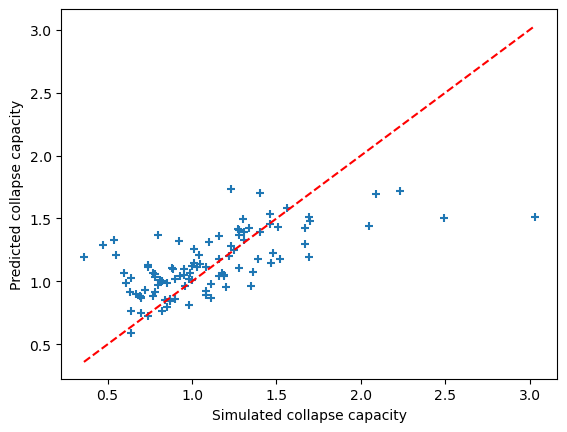

In [247]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

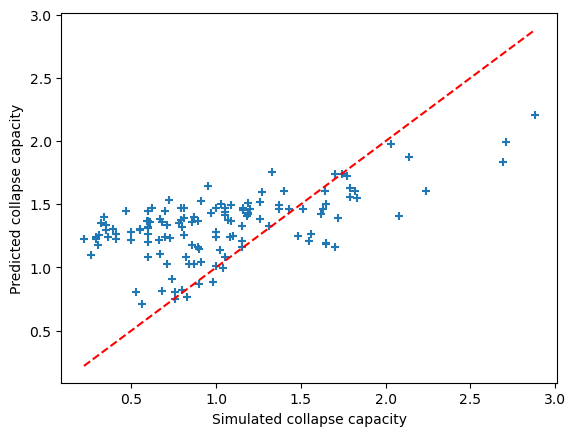

In [248]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

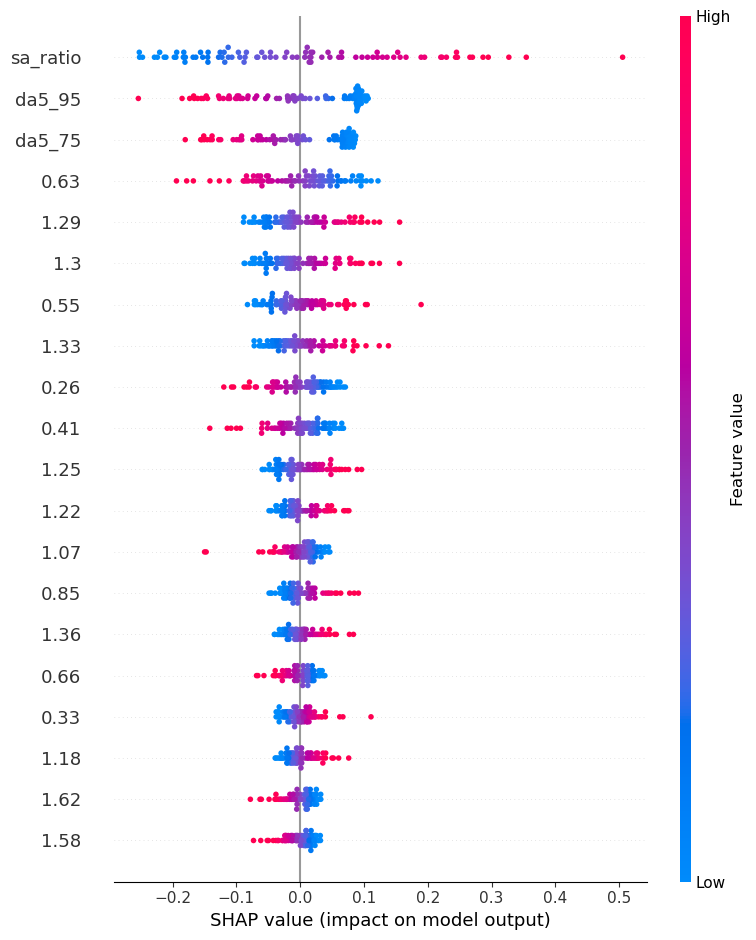

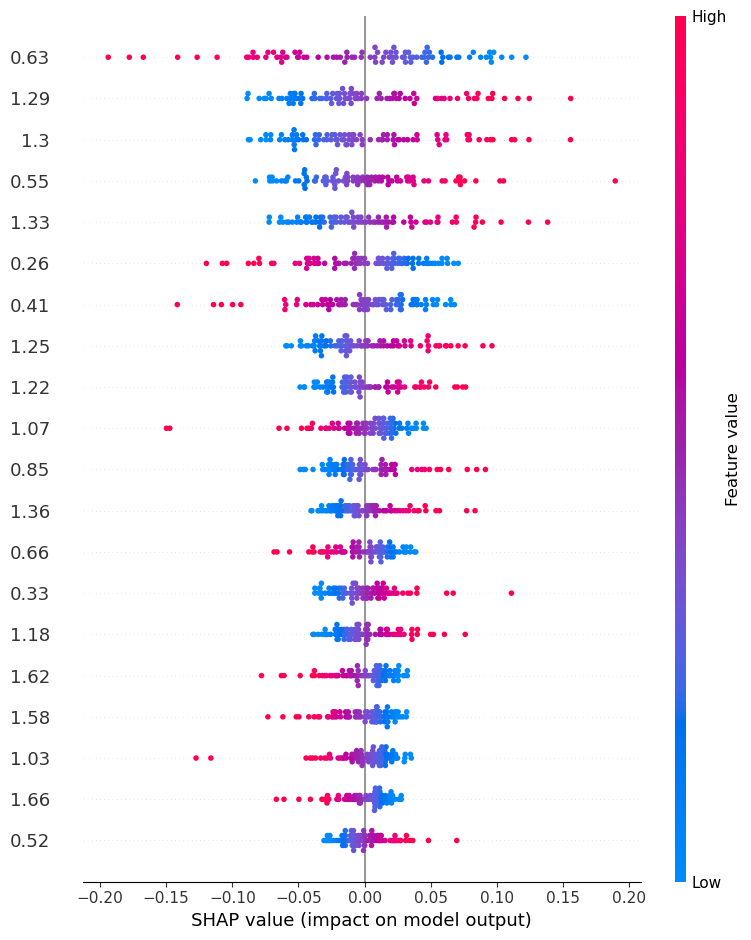

In [249]:
explainer = shap.Explainer(bayesian_model, X[0:88])
shap_values = explainer(X[0:88])
shap.summary_plot(shap_values)
shap.summary_plot(shap_values[:,:-6], X.iloc[:, :-6])

(88, 107)
88 0.43127798196935796
(78, 107)
78 0.43127798196935796
(68, 107)
68 0.43127798196935796
(58, 107)
58 0.43127798196935796
(48, 107)
48 0.43127798196935796
(38, 107)
38 0.43127798196935796
(28, 107)
28 0.43127798196935796
(18, 107)
18 0.43127798196935796
(8, 107)
8 0.43127798196935796


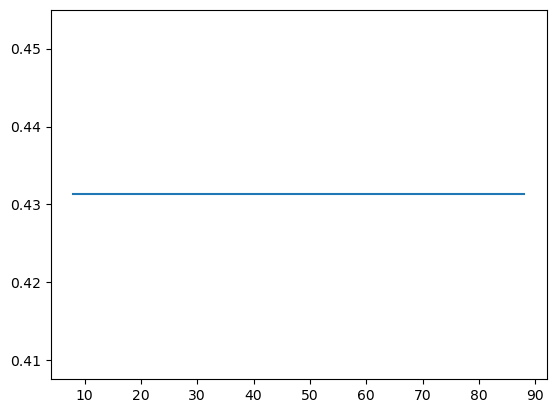

In [250]:
points = [88,78,68,58,48,38,28,18,8]
MSE_points = []

for i in points:
    n_points_cluster1 = i
    df_with_clusters = FACK(data_to_cluster, n_points_cluster1)
    df['clusters'] = df_with_clusters['new_cluster']

    X_1 = df[df['clusters']==1].iloc[:,:-2]
    # X_2 = df[df['clusters']==2].iloc[:,:-2]
    y_1 = df[df['clusters']==1].iloc[:,-2]
    # y_2 = df[df['clusters']==2].iloc[:,-1]

    bayesian_model = BayesianRidge(**best_params)
    bayesian_model.fit(X_1, y_1)

    print(X_1.shape)

    y_pred_test2 = lin_reg.predict(X_test2)
    # y_pred_test2 = lin_reg.predict(X_test2)

    mse_i = mean_squared_error(y_test2, y_pred_test2)

    MSE_points.append(mse_i)

    print(i, mse_i)
    # MSE_Test_RIDGE2 = mean_squared_error(y_test2, y_pred_test2)

mplot = plt.plot(points,MSE_points)

# Gradient Boosting (XGBoost, LightGBM, CatBoost)

Training/Validation

In [204]:
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(42)

random_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_model = GradientBoostingRegressor()

grid_search = GridSearchCV(gb_model, random_grid, cv=5)
grid_search.fit(X, y)
best_params = grid_search.best_params_


Testing

In [205]:
gb_model = GradientBoostingRegressor(**best_params)
gb_model.fit(X, y)

y_pred_test1 = gb_model.predict(X_test1)
y_pred_test2 = gb_model.predict(X_test2)

MSE_Test_GB1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_GB2 = mean_squared_error(y_test2, y_pred_test2)

print(f"GB Mean Squared Error train: {round(np.mean(MSE_Test_GB1),2)}")
print(f"GB Mean Squared Error test: {round(np.mean(MSE_Test_GB2),2)}")

GB Mean Squared Error train: 0.13
GB Mean Squared Error test: 0.58


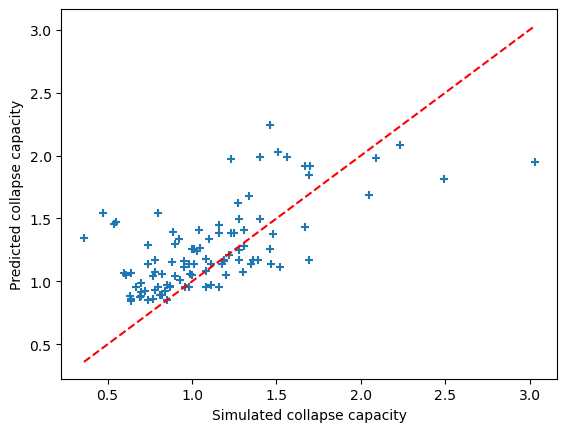

In [206]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

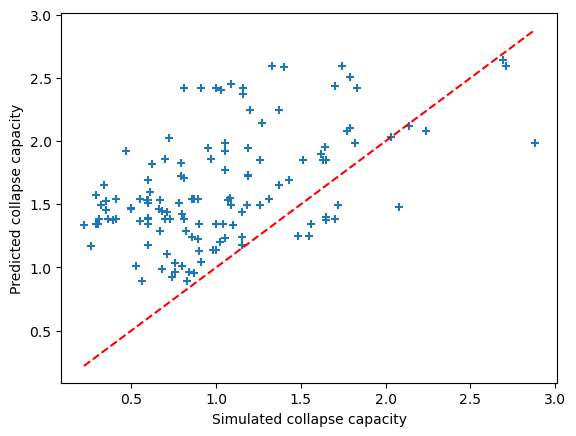

In [207]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

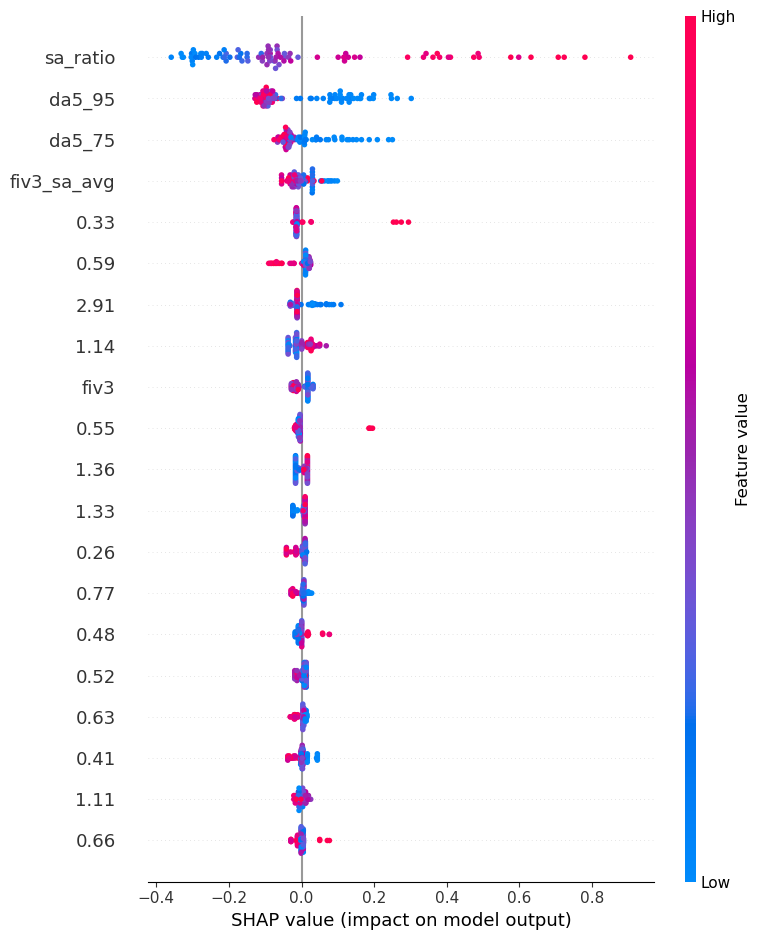

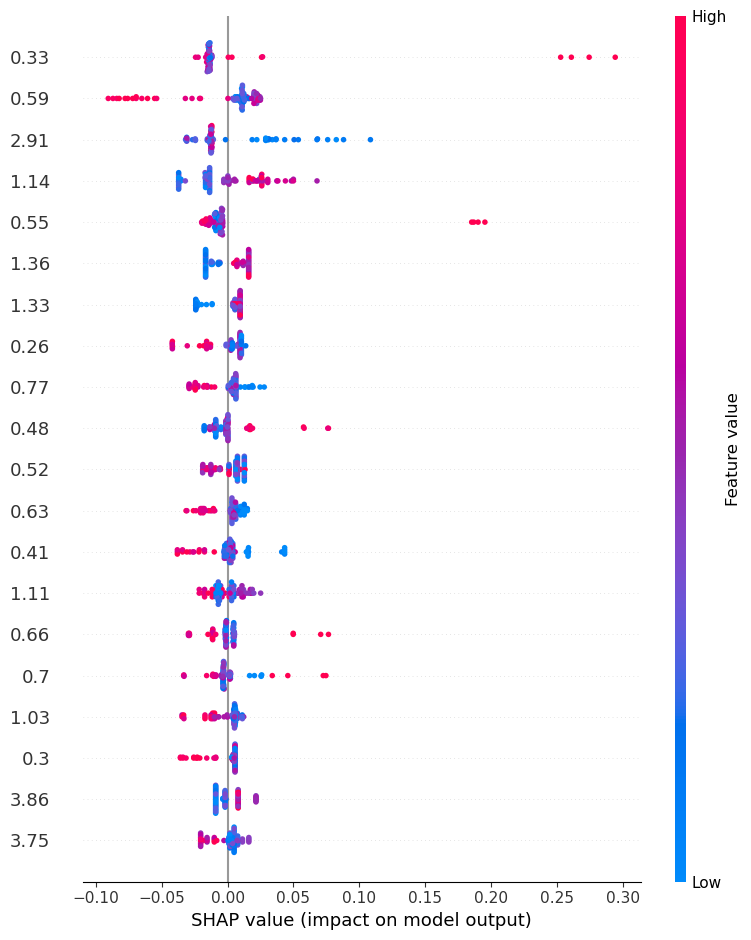

In [209]:
explainer = shap.Explainer(gb_model, X[0:88])
shap_values = explainer(X[0:88])
shap.summary_plot(shap_values)
shap.summary_plot(shap_values[:,:-6], X.iloc[:, :-6])

# SVR

Training/Validation

In [127]:
from sklearn.svm import SVR

svm_model = SVR()
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale','auto',0.0001,0.001,0.01,0.1,1],
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X, y)
best_params = grid_search.best_params_

Testing

In [128]:
svm_model = SVR(**best_params)

svm_model.fit(X, y)

y_pred_test1 = svm_model.predict(X_test1)
y_pred_test2 = svm_model.predict(X_test2)

MSE_Test_SVM1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_SVM2 = mean_squared_error(y_test1, y_pred_test1)

print(f"SVR Mean Squared Error test1: {round(np.mean(MSE_Test_SVM1),2)}")
print(f"SVR Mean Squared Error test2: {round(np.mean(MSE_Test_SVM2),2)}")

SVR Mean Squared Error test1: 9.25
SVR Mean Squared Error test2: 9.25


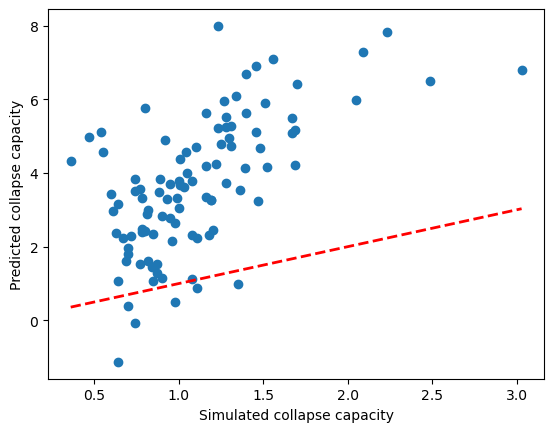

In [130]:
plt.scatter(y_test1,y_pred_test1)
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red', linewidth=2)
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

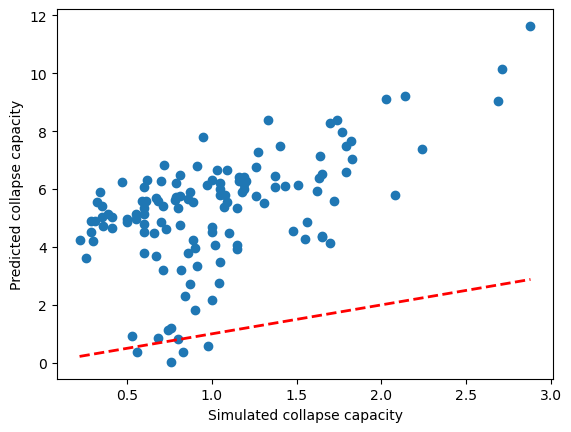

In [131]:
plt.scatter(y_test2,y_pred_test2)
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red', linewidth=2)
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

# Random Forest

Training/Validation

In [125]:
from sklearn.ensemble import RandomForestRegressor

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,cv=5)

grid_search.fit(X, y)

best_params = grid_search.best_params_

KeyboardInterrupt: 

Testing

In [120]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X, y)

y_pred_test1 = rf_model.predict(X_test1)
y_pred_test2 = rf_model.predict(X_test2)

MSE_Test_RF1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_RF2 = mean_squared_error(y_test2, y_pred_test2)

print(f"RF Mean Squared Error test1: {round(np.mean(MSE_Test_RF1),2)}")
print(f"RF Mean Squared Error test2: {round(np.mean(MSE_Test_RF1),2)}")

RF Mean Squared Error test1: 0.2
RF Mean Squared Error test2: 0.2


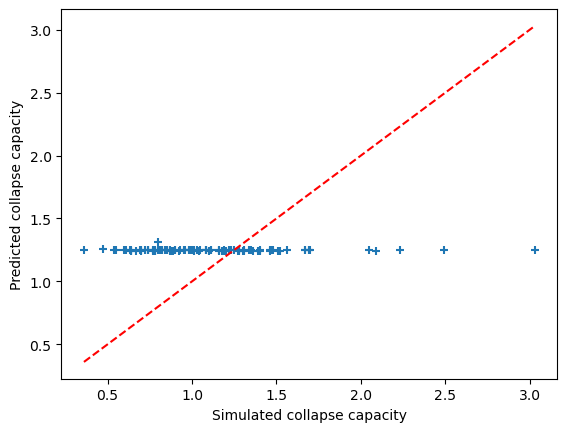

In [121]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

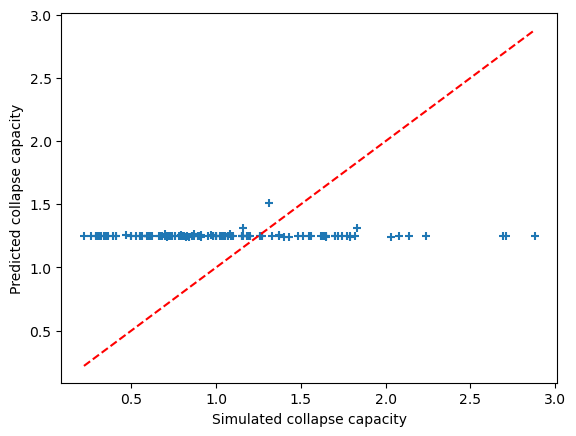

In [122]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

# Results

In [123]:
print(f"SGD Mean Squared Error Test1: {round(np.mean(MSE_Test_SGD1),2)}")
print(f"SGD Mean Squared Error Test2: {round(np.mean(MSE_Test_SGD2),2)}")
print()
print(f"RIDGE Mean Squared Error Test1: {round(np.mean(MSE_Test_RIDGE1),2)}")
print(f"RIDGE Mean Squared Error Test2: {round(np.mean(MSE_Test_RIDGE2),2)}")
print()
print(f"BLR Mean Squared Error Test1: {round(np.mean(MSE_Test_BLR1),2)}")
print(f"BLR Mean Squared Error Test2: {round(np.mean(MSE_Test_BLR2),2)}")
print()
print(f"GB Mean Squared Error Test1: {round(np.mean(MSE_Test_GB1),2)}")
print(f"GB Mean Squared Error Test2: {round(np.mean(MSE_Test_GB2),2)}")
print()
print(f"SVR Mean Squared Error Test1: {round(np.mean(MSE_Test_SVM1),2)}")
print(f"SVR Mean Squared Error Test2: {round(np.mean(MSE_Test_SVM2),2)}")
print()
print(f"RF Mean Squared Error validation: {round(np.mean(MSE_Test_RF1),2)}")
print(f"RF Mean Squared Error validation: {round(np.mean(MSE_Test_RF2),2)}")
print()
print(f"MLP Mean Squared Error validation: {round(np.mean(MSE_Test_MLP1),2)}")  
print(f"MLP Mean Squared Error validation: {round(np.mean(MSE_Test_MLP2),2)}")        

SGD Mean Squared Error Test1: 8.09
SGD Mean Squared Error Test2: 5.16

RIDGE Mean Squared Error Test1: 102.41
RIDGE Mean Squared Error Test2: 187.48

BLR Mean Squared Error Test1: 123.43
BLR Mean Squared Error Test2: 222.33

GB Mean Squared Error Test1: 1.71
GB Mean Squared Error Test2: 2.01

SVR Mean Squared Error Test1: 9.25
SVR Mean Squared Error Test2: 9.25

RF Mean Squared Error validation: 0.2
RF Mean Squared Error validation: 0.32

MLP Mean Squared Error validation: 0.2
MLP Mean Squared Error validation: 0.52


# Features Importance

T1 = 1.251, T2 = 0.84, T3= 0.54, T1_shift = 2.14

ValueError: '0.84' is not in list

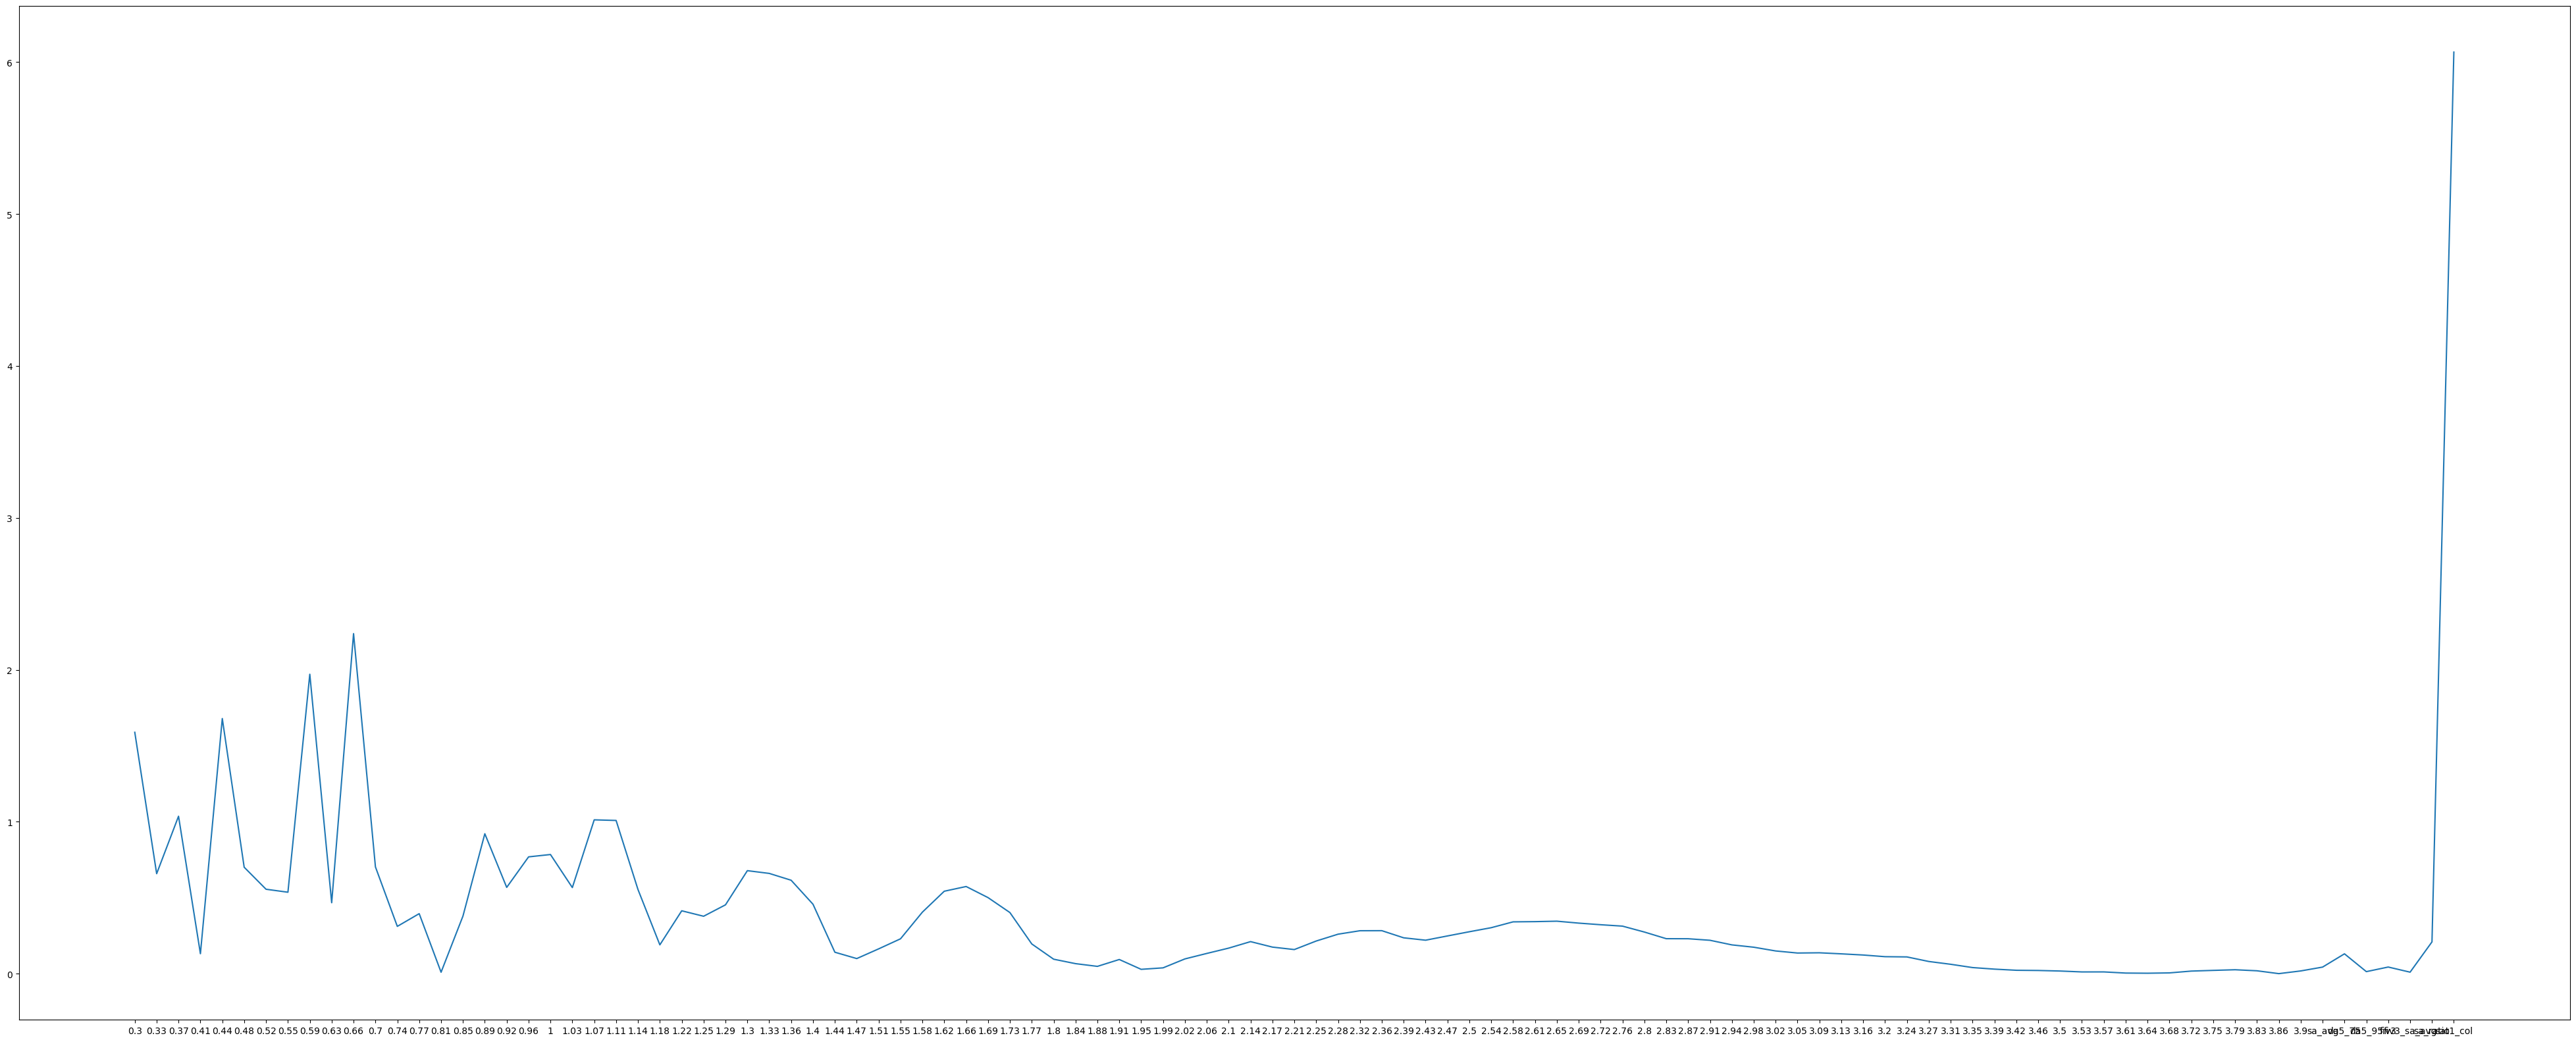

In [124]:
plt.figure(figsize=(50,20))
plt.plot(dfhead_numpy[1:X.shape[1]+1],np.abs(lin_reg.coef_))
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.84'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('1.25'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.54'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('2.14'), color='r', linestyle='--')
plt.title("Linear regression")
plt.show()


In [ ]:
plt.figure(figsize=(50,20))
plt.plot(dfhead_numpy[1:X.shape[1]+1],np.abs(bayesian_model.coef_))
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.84'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('1.25'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.54'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('2.14'), color='r', linestyle='--')
plt.title("Bayesian regression")
plt.show()

: 

In [ ]:
svm_model.coef_[0]

: 

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(dfhead_numpy[1:X.shape[1]+1],np.abs(svm_model.coef_[0]))
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.84'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('1.25'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.54'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('2.14'), color='r', linestyle='--')
plt.title("SVR regression")
plt.show()

: 

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(dfhead_numpy[1:X.shape[1]+1],np.abs(rf_model.feature_importances_))
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.84'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('1.25'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.54'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('2.14'), color='r', linestyle='--')
plt.title("Random forest")
plt.show()

: 

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(dfhead_numpy[1:X.shape[1]+1],np.abs(gb_model.feature_importances_))
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.9'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('1.25'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('0.54'), color='r', linestyle='--')
plt.axvline(x=list(dfhead_numpy[1:X.shape[1]+1]).index('2.14'), color='r', linestyle='--')
plt.title("Gradient boosting")
plt.show()

: 

# ECDF

In [ ]:
Collapse_cap = np.sort(df_numpy[:,-1])
Proba0 = 1/len(Collapse_cap)
Proba = 1/len(Collapse_cap)
ECDF = [Proba0]
for i in range(1,len(Collapse_cap)):
    Proba = Proba + Proba0
    ECDF.append(Proba)

plt.plot(Collapse_cap,ECDF)
plt.xlabel("Collapse capacity = Sa(T1) at collapse")
plt.ylabel("ECDF")
plt.show()

: 

In [ ]:
Collapse_cap = np.sort(y_test1)
Proba0 = 1/len(Collapse_cap)
Proba = 1/len(Collapse_cap)

Collapse_cap_pred = np.sort(y_pred_test)
Proba_pred0 = 1/len(Collapse_cap_pred)
Proba_pred = 1/len(Collapse_cap_pred)

ECDF_true = [Proba0]
ECDF_pred = [Proba_pred0]

for i in range(1,len(Collapse_cap)):
    Proba = Proba + Proba0
    Proba_pred = Proba_pred + Proba_pred0
    ECDF_true.append(Proba)
    ECDF_pred.append(Proba_pred)

plt.plot(Collapse_cap,ECDF_true,label="True")
plt.plot(Collapse_cap_pred,ECDF_pred,label="Predicted")
plt.xlabel("Collapse capacity = Sa(T1) at collapse")
plt.ylabel("ECDF")
plt.legend()
plt.show()


: 

# PCA

In [ ]:
from sklearn.decomposition import PCA

# Générer des données factices
np.random.seed(42)
#X = df_numpy[:,1:-1] #All data
#X = df_numpy[:,-7:] #All "resume" features
#X = df_numpy[:,1:-7] #All Sa
#X = df_numpy[:,1:50] #First 50 Sa

#X = df_scaled_numpy[:,1:-1] #All data
#X = df_scaled_numpy[:,-7:] #All "resume" features
X = df_scaled_numpy[:,1:-7] #All Sa
#X = df_scaled_numpy[:,1:50] #First 50 Sa

y = df_numpy[:,-1] #Collapse capacity

# Effectuer la PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculer le pourcentage de variance expliquée cumulatif
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot du graphique de coude
plt.plot(range(1, len(cumulative_variance_ratio[0:10]) + 1), cumulative_variance_ratio[0:10], marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Pourcentage de variance expliquée cumulatif')
plt.title('Graphique de coude pour la PCA')
plt.grid(True)
plt.show()


: 

In [ ]:
max_iterations = 10
MSE_Train_SGD = np.zeros((1,max_iterations))
MSE_Test_SGD = np.zeros((1,max_iterations))
MSE_Train_LS = np.zeros((1,max_iterations))
MSE_Test_LS = np.zeros((1,max_iterations))
SEED = 42

for i in range(max_iterations):
    np.random.seed(SEED)
    X = X_pca[:,0:3]
    y = df_numpy[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

    sgd_reg = SGDRegressor(max_iter=10000000, tol=1e-3, learning_rate='adaptive', random_state=SEED)
    lin_reg = LinearRegression()

    sgd_reg.fit(X_train, y_train)
    lin_reg.fit(X_train, y_train)

    y_pred_train = sgd_reg.predict(X_train)
    y_pred_test = sgd_reg.predict(X_test)
    
    MSE_Train_SGD[0,i] = mean_squared_error(y_train, y_pred_train)
    MSE_Test_SGD[0,i] = mean_squared_error(y_test, y_pred_test)
    
    y_pred_train = lin_reg.predict(X_train)
    y_pred_test = lin_reg.predict(X_test)
    
    MSE_Train_LS[0,i] = mean_squared_error(y_train, y_pred_train)
    MSE_Test_LS[0,i] = mean_squared_error(y_test, y_pred_test)
    
    SEED = SEED + 1
    
    

print(f"SGD Mean Squared Error train: {np.mean(MSE_Train_SGD)} ± {np.std(MSE_Train_SGD)}")

print(f"SGD Mean Squared Error test: {np.mean(MSE_Test_SGD)} ± {np.std(MSE_Test_SGD)}")

print(f"LS Mean Squared Error train: {np.mean(MSE_Train_LS)} ± {np.std(MSE_Train_LS)}")

print(f"LS Mean Squared Error test: {np.mean(MSE_Test_LS)} ± {np.std(MSE_Test_LS)}")

: 

## SHAP feature explanation